# Workflow

In [1]:
import os
from joblib import dump
from pathlib import Path

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np

import time
from scipy.stats import loguniform, randint
from scipy.stats import uniform, randint

import warnings
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
# from cuml.ensemble import RandomForestClassifier # Random forest classifier from cuml package
import xgboost as xgb

In [2]:
# !pip install --index-url https://pypi.nvidia.com --extra-index-url https://pypi.org/simple cudf-cu12




In [3]:
# Set up directory
os.chdir("/home/siti/Downloads/New Modelling")

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('AE_Synthetic_Data_Final_V02.csv')

In [4]:
print(df["LOS_Category"].value_counts())

Short stay    11942983
Long stay       779233
Name: LOS_Category, dtype: int64


In [5]:
results_folder = Path("RandomForest_folder/Version 2/Model 2")
results_folder.mkdir(parents=True, exist_ok=True) 

In [6]:
# Convert object types to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [7]:
# Create a copy of df for modelling
data = df.copy()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12722216 entries, 0 to 12722215
Data columns (total 13 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   IMD_Category           category
 1   Age_Band               category
 2   Sex                    category
 3   AE_Arrive_HourOfDay    category
 4   AE_Time_Mins           int64   
 5   AE_HRG                 category
 6   AE_Num_Diagnoses       int64   
 7   AE_Num_Investigations  int64   
 8   AE_Num_Treatments      int64   
 9   AE_Arrival_Mode        category
 10  ICD10_Chapter_Code     category
 11  TFC                    category
 12  LOS_Category           category
dtypes: category(9), int64(4)
memory usage: 497.4 MB


In [8]:
# Define the features and target
feature_cols = data.columns[data.columns != 'LOS_Category']
X = data[feature_cols]
y = data['LOS_Category']


# Step 1: Map the Outcome Variable

In [9]:
y = y.map({'Short stay': 1, 'Long stay': 0})

In [10]:
print(y.value_counts())

1    11942983
0      779233
Name: LOS_Category, dtype: int64


# Step 2: Split Data

In [11]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

**Overall Proportions:**

- **Test set**: 15% of the original dataset
- **Validation set**: 0.1765 * 0.85 = 0.15 or 15% of the original dataset
- **Training set**: 1−0.15−0.15 = 0.7 or 70% of the original dataset

So, by using this two-step splitting, we've achieved a 70-15-15 split for the training, validation, and test datasets, respectively.

# Step 3: One-Hot Encoding 

In [12]:
# Your nominal columns
nominal_columns = ['Sex', 'AE_Arrival_Mode', 'ICD10_Chapter_Code', 'TFC']

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=nominal_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Get all columns in X_train after one-hot encoding
all_columns = X_train.columns

# Ensure X_val has the same columns as X_train
for col in all_columns:
    if col not in X_val.columns:
        X_val[col] = 0

# Ensure X_test has the same columns as X_train
for col in all_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns in X_val and X_test to match X_train's order
X_val = X_val[all_columns]
X_test = X_test[all_columns]


# Step 4: Ordinal Encoding

In [13]:
orders = {
    'IMD_Category': ['Most deprived 20%', '20% - 40%', '40 - 60%', '60% - 80%', 'Least deprived 20%'],
    'Age_Band': ['01-17', '18-24', '25-44', '45-64', '65-84', '85+'],
    'AE_Arrive_HourOfDay': ['01-04','05-08','09-12','13-16','17-20','21-24'],
    'AE_HRG': ['Nothing', 'Low', 'Medium', 'High']
}

# Loop through each column and its respective order to encode
for col, order in orders.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_val[col] = ordinal_encoder.transform(X_val[[col]])
    X_test[col] = ordinal_encoder.transform(X_test[[col]])

# Step 5: Undersampling the majority class

In [14]:
# Initialize the random undersampler
rus = RandomUnderSampler(random_state=42)

# Fit and transform the data with the undersampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Counts of each class
print(y_train_resampled.value_counts())

# Proportions of each class
print(y_train_resampled.value_counts(normalize=True) * 100)


0    545444
1    545444
Name: LOS_Category, dtype: int64
0    50.0
1    50.0
Name: LOS_Category, dtype: float64


# Step 6: Standardize Dataset

In [15]:
# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
print(X_train_scaled.shape)
print(y_train_resampled.shape)

(1090888, 21)
(1090888,)


# Step 7: RFECV

Perform RFECV on the training set (not including the validation set).


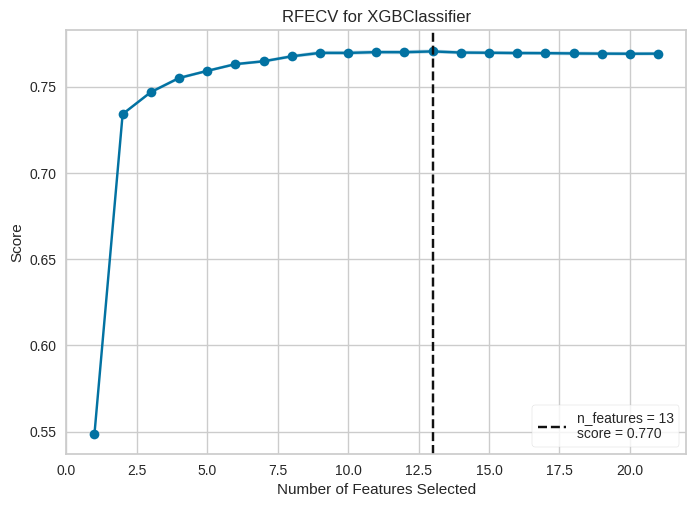

RFECV took 1644.05 seconds.


In [17]:
from yellowbrick.model_selection import RFECV

# Number of cores to use
n_cores = 7  # Adjust as necessary

# Record the start time
start_time = time.time()

# Initialize the XGBoost estimator to mimic Random Forest
estimator = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    booster='gbtree',
    n_estimators=100,  # Number of trees
    tree_method='hist',
    max_depth=6,
    n_jobs=n_cores,  # Changed from deprecated nthread to n_jobs
    subsample=0.8,  # Randomly sample 80% of the training data before growing trees
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42
)

# Initialize RFECV
visualizer = RFECV(estimator, step=1, cv=5, scoring='roc_auc', n_jobs=n_cores)

# Assuming X_train_scaled and y_train_resampled are your scaled feature matrix and target array
# Fit the data to the visualizer
visualizer.fit(X_train_scaled, y_train_resampled)

# Show the visualizer
visualizer.show(outpath= results_folder / "RFECV.png")

# Record the end time
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"RFECV took {duration:.2f} seconds.")



In [20]:
feature_names = X_train.columns

# Map the selected features to the original column names
selected_features = [feature for mask, feature in zip(visualizer.support_, feature_names) if mask]

print("Selected Features:", selected_features)



Selected Features: ['Age_Band', 'AE_Arrival_Mode_Not known', 'AE_Arrival_Mode_Other', 'ICD10_Chapter_Code_Other', 'ICD10_Chapter_Code_X', 'ICD10_Chapter_Code_XI', 'ICD10_Chapter_Code_XIV', 'ICD10_Chapter_Code_XIX', 'ICD10_Chapter_Code_XVIII', 'TFC_180', 'TFC_300', 'TFC_420', 'TFC_OTHER']


# Step 8: Hyperparameter Tuning with Randomized Search CV

After feature selection, use RandomizedSearchCV for hyperparameter tuning on the training set. The cross-validation within RandomizedSearchCV uses multiple train-validation splits of the training data.



In [21]:
# Extract columns from the scaled and resampled training set using the list of selected features
selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
X_train_selected_scaled = X_train_scaled[:, selected_feature_indices]

# Define the hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(1, 10),
    'min_samples_split': uniform(0.1, 1),
    'min_samples_leaf': uniform(0.1, 0.5),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

These parameters caused overfitting, with recall having perfect 1.0 score. Changed these to the below and added class weights to the negative class to penalize wrong predictions on this class. 

Hyperparameter results for the above:
Best parameters for RF: {'bootstrap': False, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 0.14883605700319194, 'min_samples_split': 0.7842330265121569, 'n_estimators': 363}
Best ROC-AUC score for RF: 0.7265949128306726
Hyperparameter tuning for RF took 702.91 seconds.

# Setting balanced class weight
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RF: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.11029224714790123, 'min_samples_split': 0.9729188669457949, 'n_estimators': 393}
Best ROC-AUC score for RF: 0.728006264802298
Hyperparameter tuning for RF took 1455.48 seconds.

In [51]:
weight_for_0 = 1 / 779233
weight_for_1 = 1 / 11942983

normalized_weight_for_0 = weight_for_0 / (weight_for_0 + weight_for_1)
normalized_weight_for_1 = weight_for_1 / (weight_for_0 + weight_for_1)

class_weights = {0: normalized_weight_for_0, 1: normalized_weight_for_1}

param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(1, 10),
    'min_samples_split': uniform(0.1, 0.9),  # Changed upper limit to 0.9
    'min_samples_leaf': uniform(0.1, 0.5),
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'bootstrap': [True, False]
}

# Record the start time
start_time = time.time()

random_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight=class_weights), 
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=7,
    random_state=42,
    scoring='roc_auc'
)
# Execute your RandomizedSearchCV using the selected and scaled features
random_search.fit(X_train_selected_scaled, y_train_resampled)

# Save the cv_results_ to a DataFrame and then to a CSV file
cv_results_df = pd.DataFrame(random_search.cv_results_)
cv_results_df.to_csv(results_folder /'cv_results.csv', index=False)

# Print results
print("Best parameters for RF:", random_search.best_params_)
print("Best ROC-AUC score for RF:", random_search.best_score_)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Hyperparameter tuning for RF took {duration:.2f} seconds.")

# Save the model
dump(random_search, results_folder / 'random_search_model.joblib')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RF: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.25212112147976884, 'min_samples_split': 0.5722807884690141, 'n_estimators': 335}
Best ROC-AUC score for RF: 0.726414413426094
Hyperparameter tuning for RF took 1455.84 seconds.


['RandomForest_folder/Version 2/Model 2/random_search_model.joblib']

# Step 9: Train the whole dataset with best hyperparameters


In [52]:
# Extracting selected features for validation, and test sets:

X_val_selected_scaled = X_val_scaled[:, selected_feature_indices]
X_test_selected_scaled = X_test_scaled[:, selected_feature_indices]

In [53]:
# Define the best hyperparameters
best_params = random_search.best_params_

# Record the start time
start_time = time.time()

# Train a RF model using the best hyperparameters on the training set
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_selected_scaled, y_train_resampled)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for RF took {duration:.2f} seconds.")

Training for RF took 26.25 seconds.


# Step 10: Predict and Evaluate on Validation Set

In [54]:
y_val_pred = best_model.predict(X_val_selected_scaled)
y_val_prob = best_model.predict_proba(X_val_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the validation set using multiple metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_prob)  # Note: roc_auc_score uses probability estimates
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

# Print the metrics
print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("ROC-AUC:", val_roc_auc)
print("F1 Score:", val_f1)
print("Precision:", val_precision)
print("Recall:", val_recall)


Validation Metrics:
Accuracy: 0.6470931563706513
ROC-AUC: 0.7214717104499975
F1 Score: 0.7746590827735852
Precision: 0.9669181848930386
Recall: 0.6461754924104798


# Step 11: Final Model Training and Test Evaluation

Finally, we train on the combined train+validation data and test on the test set.

In [55]:
# Record the start time
start_time = time.time()

# Combine the training and validation sets
X_combined = np.concatenate([X_train_selected_scaled, X_val_selected_scaled], axis=0)
y_combined = np.concatenate([y_train_resampled, y_val], axis=0)

# Train the final model on the combined set
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_combined, y_combined)

# Record the end time
end_time = time.time()
duration = end_time - start_time

print(f"Training RF took {duration:.2f} seconds.")

Training RF took 87.12 seconds.


In [56]:
# Save the model
dump(final_model, results_folder / 'final_model_RF.joblib')

['RandomForest_folder/Version 2/Model 2/final_model_RF.joblib']

# Step 12: Predict on test set

In [57]:
# Predict on the test set
y_test_pred = final_model.predict(X_test_selected_scaled)
y_test_prob = final_model.predict_proba(X_test_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the test set using multiple metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'ROC-AUC': roc_auc_score(y_test, y_test_prob),
    'F1 Score': f1_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred)
}

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Metrics:
Accuracy: 0.9387502076419577
ROC-AUC: 0.719287424770931
F1 Score: 0.9684075895302993
Precision: 0.9387502076419577
Recall: 1.0
Confusion Matrix:
[[      0  116885]
 [      0 1791448]]


# Step 13: Save the metrics

In [58]:
# Save all metrics in a csv file

# Convert the metrics to a DataFrame
metrics_df = pd.DataFrame(list(test_metrics.items()), columns=['Metric', 'Value'])

# Save to CSV
output_path = results_folder / "Model2_Performance_metrics.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")

Metrics saved to: RandomForest_folder/Version 2/Model 2/Model2_Performance_metrics.csv


# ROC-AUC Curve

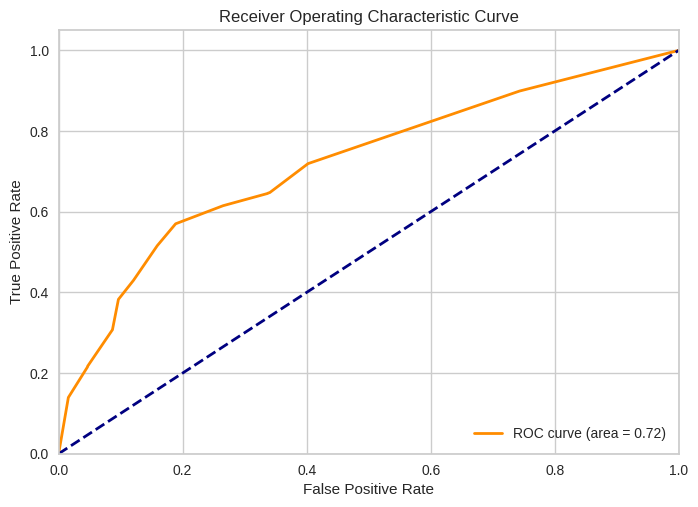

In [59]:
# y_test_prob contains the predicted probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig(results_folder / "roc_auc.png", dpi=300)
plt.show()


# Precision-Recall Curve

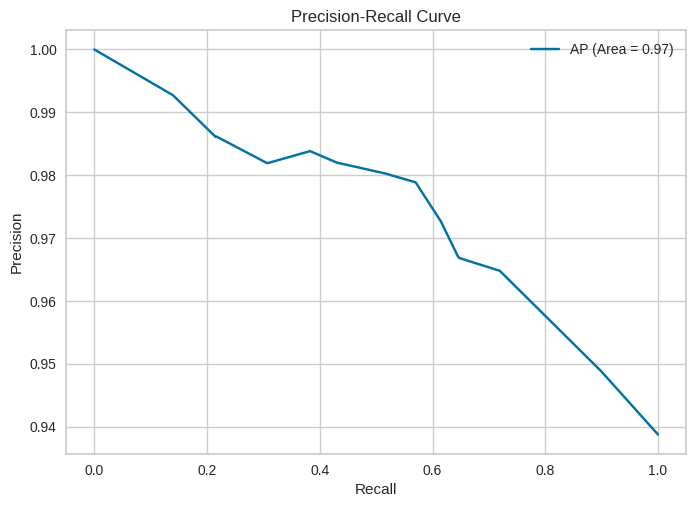

In [60]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
average_precision = average_precision_score(y_test, y_test_prob)

plt.figure()
plt.plot(recall, precision, label='AP (Area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig(results_folder / "precision_recall.png", dpi=300)
plt.show()

# Calculate Error

In [61]:
# Predict on training set
y_combined_pred = final_model.predict(X_combined)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_error = 1 - combined_accuracy

# Predict on validation set
y_val_pred = final_model.predict(X_val_selected_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

# Predict on test set
y_test_pred = final_model.predict(X_test_selected_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print(f"Combined Error: {combined_error:.3f}")
print(f"Validation Error: {val_error:.3f}")
print(f"Test Error: {test_error:.3f}")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Combined Error', 'Validation Error', 'Test Error'],
    'Value': [combined_error, val_error, test_error]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv(results_folder / 'Model_Metrics.csv', index=False)

Combined Error: 0.221
Validation Error: 0.061
Test Error: 0.061


# Feature Importance


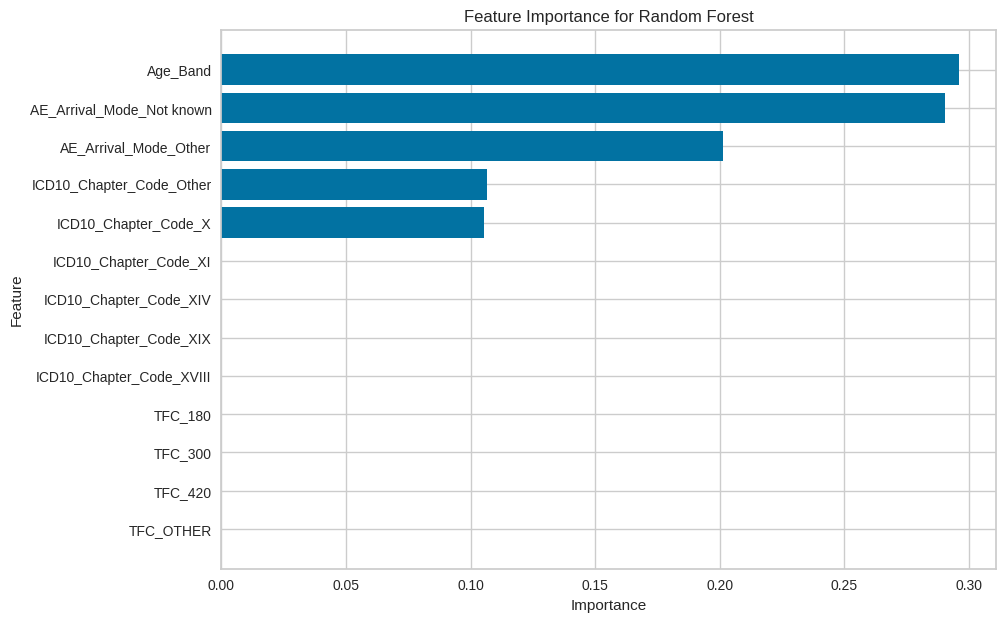

In [62]:

# Retrieve Feature Importance
importances = final_model.feature_importances_

# Match Feature Importance to Feature Names:
feature_names = [X_train.columns[i] for i in selected_feature_indices]

# Sort Features by Importance:
sorted_idx = np.argsort(importances)[::-1]

# Plot

plt.figure(figsize=(10, 7))
plt.barh(feature_names, importances[sorted_idx])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(results_folder / "Feature_Importance.png", dpi=300)
plt.show()

In [63]:
# Create a DataFrame to hold feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on the importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save the DataFrame to a CSV file
feature_importance_df.to_csv(results_folder / 'Feature_Importance.csv', index=False)